In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from sklearn.model_selection import train_test_split

import helpers

sys.path.append(os.path.join('..'))
from adp.curve import * 
from adp.utility import *
from adp.plot import *
from adp.funcs import *

In [2]:
# Fetch data and train model
D = helpers.fetch_1980_data() 
X, y, dtypes, feature_labels = D['X'], D['y'], D['dtypes'], D['feature_labels']

# Show stats
print(D['dataframe'].dtypes)
D['dataframe'].head()

WHITE         category
ALCHY         category
JUNKY         category
PAROLE        category
MARRIED       category
FELONY        category
WORKREL       category
PROPTY        category
PERSON        category
MALE          category
PRIORS         float64
SCHOOL         float64
RULE           float64
AGE (Year)     float64
TSERVD         float64
FOLLOW         float64
RECID         category
dtype: object


,WHITE,ALCHY,JUNKY,PAROLE,MARRIED,FELONY,WORKREL,PROPTY,PERSON,MALE,PRIORS,SCHOOL,RULE,AGE (Year),TSERVD,FOLLOW,RECID
1,1,0,0,1,0,1,0,1,0,1,0.0,10.0,1.0,19.333333,10.0,52.0,1
4,1,0,1,1,0,1,0,1,0,1,0.0,10.0,2.0,20.916667,23.0,46.0,0
5,1,0,1,0,0,1,0,1,0,1,0.0,11.0,0.0,22.750000,2.0,57.0,0
7,1,0,1,1,0,0,0,0,0,1,1.0,9.0,13.0,20.500000,36.0,46.0,1
9,0,0,1,0,0,0,1,0,0,1,1.0,11.0,4.0,24.666667,53.0,52.0,0


In [3]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)
model_names = ['RBFSVM-2']
model_dicts = helpers.create_and_train_models(model_names, dtypes, X_train, y_train, X_test=X_test, y_test=y_test)
model = model_dicts[0]['model'] 

from sklearn.metrics import accuracy_score
acc = accuracy_score((model(X_test)>=0) + np.zeros(y_test.shape[0]), y_test)
# Accuracy should be 0.662020905923345
print(acc) 
# Best params should be {'svc__C': 3.593813663804626, 'svc__gamma': 0.021544346900318832}
print(model_dicts[0]['estimator'].best_params_) 

Loading fitted model from cache via file cached_model_c75ddd63fa3d30d50cd3bc19ab044a6297785a9d.pkl
0.662020905923345
{'svc__C': 3.593813663804626, 'svc__gamma': 0.021544346900318832}


In [4]:
idx = 100
x0 = X_test[idx, :]
print ('MALE:', x0[np.where(feature_labels == 'MALE')[0][0]])
print ('WHITE:', x0[np.where(feature_labels == 'WHITE')[0][0]])
print('dtypes:')
print(dtypes)

MALE: 1.0
WHITE: 1.0
dtypes:
WHITE         category
ALCHY         category
JUNKY         category
PAROLE        category
MARRIED       category
FELONY        category
WORKREL       category
PROPTY        category
PERSON        category
MALE          category
PRIORS         float64
SCHOOL         float64
RULE           float64
AGE (Year)     float64
TSERVD         float64
FOLLOW         float64
dtype: object


In [5]:
def show_flipped_model(feature='WHITE', max_show=3, target_idx=None, plot_curve_vals_kwargs=None,
                       figscale=None,
                       subplot_kwargs=None):
    if target_idx is None:
        target_idx = [100, 150]
    if figscale is None:
        figscale = np.array([5, 2])
    if subplot_kwargs is None:
        subplot_kwargs = {}
    if plot_curve_vals_kwargs is None:
        plot_curve_vals_kwargs = {}
    def feature_flipped_model(X): # gender_flipped_model
        idx = np.where(feature_labels == feature)[0][0]
        X_copy = copy.deepcopy(X)
        X_copy[:, idx] = ((X_copy[:,idx]+1)%2)
        return model(X_copy)
    targets = [X_test[i] for i in target_idx]
    n_targets = len(targets)

    fig, axes_mat = plt.subplots(max_show, n_targets, figsize=np.array(figscale) *[n_targets, max_show], 
                                 sharey=True, **subplot_kwargs)
    if max_show == 1 and n_targets == 1:
        axes_mat = np.array(axes_mat).reshape(1, 1)
    if max_show == 1:
        axes_mat = axes_mat.reshape(1, -1)
    if n_targets == 1:
        axes_mat = axes_mat.reshape(-1, 1)
    for x0, axes in zip(targets, axes_mat.T):
        print({k: v for k, v in zip(feature_labels, x0)})
        utility = ModelContrastUtility(model=model, other_model=feature_flipped_model)
        curves, sorted_idx = coordinate_explainer(
            x0, utility, X_train, dtypes=dtypes, feature_labels=feature_labels, 
            max_show=max_show, axes=axes, tick_rotation=0, **plot_curve_vals_kwargs)

{'WHITE': 1.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 1.0, 'MARRIED': 0.0, 'FELONY': 0.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 9.0, 'RULE': 7.0, 'AGE (Year)': 22.25, 'TSERVD': 40.0, 'FOLLOW': 52.0}
{'WHITE': 0.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 0.0, 'MARRIED': 0.0, 'FELONY': 1.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 13.0, 'RULE': 5.0, 'AGE (Year)': 25.916666666666668, 'TSERVD': 90.0, 'FOLLOW': 57.0}


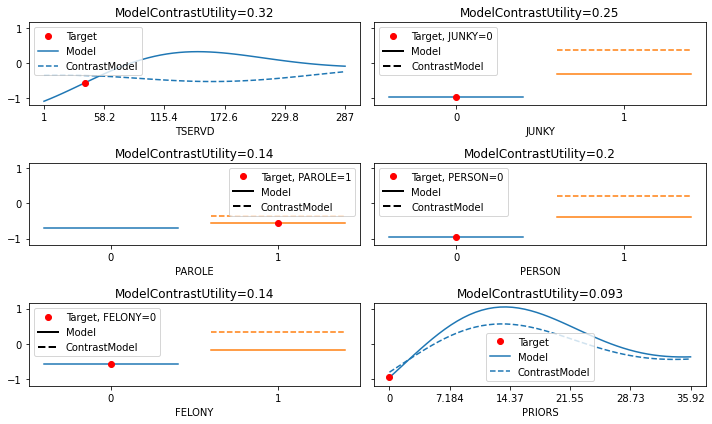

In [6]:
show_flipped_model(feature='WHITE')

{'WHITE': 1.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 1.0, 'MARRIED': 0.0, 'FELONY': 0.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 9.0, 'RULE': 7.0, 'AGE (Year)': 22.25, 'TSERVD': 40.0, 'FOLLOW': 52.0}
{'WHITE': 0.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 0.0, 'MARRIED': 0.0, 'FELONY': 1.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 13.0, 'RULE': 5.0, 'AGE (Year)': 25.916666666666668, 'TSERVD': 90.0, 'FOLLOW': 57.0}


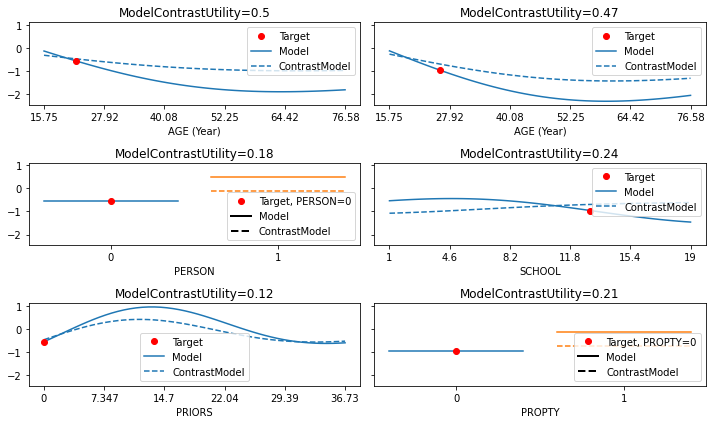

In [7]:
show_flipped_model(feature='MALE')

{'WHITE': 1.0, 'ALCHY': 0.0, 'JUNKY': 0.0, 'PAROLE': 1.0, 'MARRIED': 0.0, 'FELONY': 0.0, 'WORKREL': 1.0, 'PROPTY': 0.0, 'PERSON': 0.0, 'MALE': 1.0, 'PRIORS': 0.0, 'SCHOOL': 9.0, 'RULE': 7.0, 'AGE (Year)': 22.25, 'TSERVD': 40.0, 'FOLLOW': 52.0}


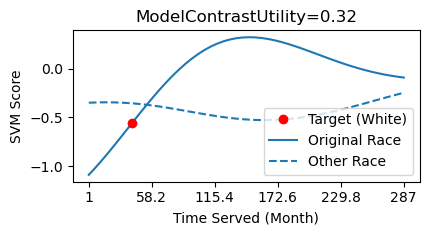

In [8]:
# Figure for paper
show_flipped_model(feature='WHITE', target_idx=[100], max_show=1,
                   figscale=np.array([6, 3.5])*0.7, subplot_kwargs=dict(dpi=100),
                   plot_curve_vals_kwargs=dict(
                       model_label='Original Race', other_model_label='Other Race', target_label='Target (White)',
                   ))
ax = plt.gca()
ax.set_ylabel('SVM Score')
ax.set_xlabel('Time Served (Month)')
plt.savefig('bias-race.pdf', bbox_inches='tight', pad_inches=0)